<a href="https://colab.research.google.com/github/Sofigam00s/Spark/blob/main/Clustering_con_Spark_Gamallo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parcial 2 Procesamiento de datos
## Alumna: Gamallo Sofia Antonia
## Dni: 42432866

## Aplicación de clustering con Spark

En este parcial voy a desarrollar prácticas de Spark para aplicarlas a un dataset elegido, con el objetivo de explicar lo ya visto en clases e implemetar un modelo de clustering con MLlib como investigación adicional.

Elegí un dataset sobre un comercio minorista online (https://archive.ics.uci.edu/dataset/502/online+retail+ii)

El objetivo es realizar un preprocesamiento de datos y dejar el dataset listo para aplicar un modelo de clustering con el fin de hacer una segmentación de clientes.

## Primera parte: carga del dataset

In [ ]:
# Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Análisis y visulización
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Abrir la sesion de Spark
spark = SparkSession.builder.appName('Online Retail').getOrCreate()


In [ ]:
#Cargar el dataset
df = spark.read.csv('OnlineRetail2.csv', header = True, inferSchema = True)

In [ ]:
#Mostrar la estructura inicial para verificar que se haya cargado bien el dataset
df.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



### Descripción del dataset y las variables:

El dataset contiene transacciones comerciales en un determinado periodo de tiempo de un comercio online.

* Invoice: Número de factura de la compra.
* StockCode: Código de identificación del producto.
* Description: Nombre o descripción del producto.
* Quantity: Cantidad de unidades compradas en una transacción.
* InvoiceDate: Fecha y hora de la compra.
* Price: Precio unitario del producto comprado.
* Customer ID: Identificación única del cliente.
* Country: País del cliente que realizó la compra.
### Objetivo del clustering:

El objetivo para este dataset es aplicar clustering con el fin de agrupar diferentes tipos de clientes (segmentación de clientes). Esta información se podría utilizar en el comercio para generar un servicio más personalizado.

## Segunda parte: análisis exploratorio y prepocesamiento de los datos

En esta parte voy a analizar el dataset para ver que tipo de variables tiene, que procesamiento debo hacer para poder aplicar el clustering adecuadamente, ya sea eliminando variables, imputando valores nulos, tranformando variables categoricas a numericas, etc.

In [ ]:
df.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|2009-12-01 07:45:00| 1.2

In [ ]:
num_rows = df.count()
num_colum = len(df.columns)
print(f'El dataset tiene {num_rows} filas y {num_colum} columnas')


El dataset tiene 525461 filas y 8 columnas


In [ ]:
# Análisis de tipos de datos
print("ipos de datos por columna:")
for col_name, col_type in df.dtypes:
    print(f"   {col_name}: {col_type}")

ipos de datos por columna:
   Invoice: string
   StockCode: string
   Description: string
   Quantity: int
   InvoiceDate: timestamp
   Price: double
   Customer ID: double
   Country: string


In [ ]:
df.describe().show()

+-------+-----------------+-----------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|          Invoice|        StockCode|         Description|          Quantity|            Price|       Customer ID|    Country|
+-------+-----------------+-----------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|           525461|           525461|              522533|            525461|           525461|            417534|     525461|
|   mean|514496.9241788484|30518.37992495103|  22226.666666666668|10.337667305470815| 4.68883447867763|15360.645477973052|       NULL|
| stddev|14439.20949446552|20693.16815285468|   646.8974674037095|107.42411026879782|146.1269139529264|1680.8113157457146|       NULL|
|    min|           489434|            10002|  DOORMAT UNION J...|             -9600|        -53594.36|           12346.0|  Australia|
|    max|          C538164|                m|          

### Eliminar variables:

Como el objetivo es segmentar clientes, voy a eliminar las variables que sean irrelevantes o innecesarias para el modelo de clustering, en este caso las variables son las siguientes:

* Invoice: la elimino porque el número de factura no determina un tipo de cliente.
* Description: la elimino porque es una descripcion del producto que se compro, sin embargo esta información la puedo obtener con el stockcode, que significa lo mismo pero de manera numérica.
* InvoiceDate: si quisiera un análisis del comercio en el tiempo, la utilizaría, pero como estoy tratando de identificar diferentes tipos de clientes, esta variable no me aporta una información necesaria.


In [ ]:
# Eliminar variables
df = df.drop('Invoice', 'Description', 'InvoiceDate')

In [ ]:
# Contar valores nulos en cada columna
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+---------+--------+-----+-----------+-------+
|StockCode|Quantity|Price|Customer ID|Country|
+---------+--------+-----+-----------+-------+
|        0|       0|    0|     107927|      0|
+---------+--------+-----+-----------+-------+





> No hay valores nulos a excepción del CustomerID, y justo es una variable fundamental para la segmentación de clientes. Como tengo que aplicar clustering, sería un error(que cometí y arreglé) imputar los datos con un valor que se defina como 'Uknown', por ejemplo, porque generaría un grupo específico de cliente que además lo identificaría como un 'cliente gigante'. Por lo tanto la mejor opción es eliminar las final donde el CustomerID sea nulo.



In [ ]:
df = df.na.drop(subset=["Customer ID"])


In [ ]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---------+--------+-----+-----------+-------+
|StockCode|Quantity|Price|Customer ID|Country|
+---------+--------+-----+-----------+-------+
|        0|       0|    0|          0|      0|
+---------+--------+-----+-----------+-------+





### Eliminación de outliers

Voy a eliminar los outliers de las variables 'Quantity' y 'Price' que son las que más pueden afectar al modelo de Kmeans

In [ ]:
# Calcular percentiles (Q1 y Q3)
quantiles = df.approxQuantile(["Quantity", "Price"], [0.25, 0.75], 0.01)
Q1_Qt, Q3_Qt = quantiles[0]
Q1_Pr, Q3_Pr = quantiles[1]
IQR_Qt = Q3_Qt - Q1_Qt
IQR_Pr = Q3_Pr - Q1_Pr

# Filtrar datos dentro de 1.5 * IQR
df_clean = df.filter(
    (col("Quantity") >= Q1_Qt - 1.5 * IQR_Qt) & (col("Quantity") <= Q3_Qt + 1.5 * IQR_Qt) &
    (col("Price") >= Q1_Pr - 1.5 * IQR_Pr) & (col("Price") <= Q3_Pr + 1.5 * IQR_Pr)
)

### Transformar variables

En esta parte voy a normalizar los datos, para eso primero tengo que codifcar las variables 'stockcode' y 'country' para conservar su característica categórica en tipo numérico.

Luego con VectorAssambler vectorizo todas las variables y finalmente con MinMax las normalizo.

In [ ]:
# Codificar StockCode y Country
indexer_stock = StringIndexer(inputCol="StockCode", outputCol="StockCode_Index")
indexer_country = StringIndexer(inputCol="Country", outputCol="Country_Index")

df = indexer_stock.fit(df).transform(df)
df = indexer_country.fit(df).transform(df)


In [ ]:
# Vectorizar
features = ["StockCode_Index", "Quantity", "Price", "Customer ID", "Country_Index"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(df)


In [ ]:
# Normalizar
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

## Tercera parte: aplicación del modelo

### Utilizar PCA para reducir la dimensionalidad

Voy a aplicar PCA para reducir la dimensionalidad de los datos y mejorar la efciencia de los clústers, así se puede trabajar con menos información y facilitar la visualiación.

In [ ]:
# Aplicar PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Mostrar las nuevas variables reducidas
df_pca.select("pca_features").show(5, truncate=False)

# Porcentaje de varianza explicada por cada componente
explained_variance = pca_model.explainedVariance.toArray()
print("Varianza explicada por cada componente:", explained_variance)

+-------------------------------------------+
|pca_features                               |
+-------------------------------------------+
|[-0.12734517901637743,-0.1013705498465314] |
|[-0.12670187116450632,-0.08103392859481824]|
|[-0.12556431410111832,-0.0450728289606398] |
|[-0.13101655932704462,-0.21743841374052802]|
|[-0.12405013081166105,0.002792517928979674]|
+-------------------------------------------+
only showing top 5 rows

Varianza explicada por cada componente: [0.68818378 0.27293822]


El PCA pudo explicar el 95% de la varianza, es decir, retiene ese porcetanje de información en solo dos dimensiones. Es un muy buen porcentaje para aplicar Kmeans

### Aplicar Kmean

Ahora con los datos normalizados y reducidos, voy a hacer primero una evaluación de clustering utilizando la métrica de silhouette score para encontrar el valor óptimo de k.

In [ ]:
evaluator = ClusteringEvaluator(featuresCol='pca_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2, 8):
    kmeans = KMeans(k=k, seed=42, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    predictions = model.transform(df_pca)
    score = evaluator.evaluate(predictions)
    print(f"Silhouette score para k={k}: {score:.4f}")


Silhouette score para k=2: 0.6510
Silhouette score para k=3: 0.6582
Silhouette score para k=4: 0.5760
Silhouette score para k=5: 0.4999
Silhouette score para k=6: 0.5778
Silhouette score para k=7: 0.5675


El k más óptimo son 3 clústeres, con un score de 65%. No es un porcentaje perfecto pero sí decente, así que voy implementar el modelo con esa cantidad.

In [ ]:
# Modelo con k=3
kmeans_3 = KMeans(k=3, featuresCol="pca_features", seed=42)
model_3 = kmeans_3.fit(df_pca)
df_k3 = model_3.transform(df_pca)

In [ ]:
# Análisis estadístico por cluster
cluster_stats = df_k3.groupBy("prediction").agg(
    count("*").alias("NumTransacciones"),
    avg("Quantity").alias("CantidadPromedio"),
    avg("Price").alias("PrecioPromedio"),
    avg("StockCode_Index").alias("ProductoPromedio"),
    avg("Country_Index").alias("PaisPromedio"),
    countDistinct("Customer ID").alias("ClientesUnicos"),
    sum(col("Quantity") * col("Price")).alias("GananciaTotal")
).orderBy("prediction")

cluster_stats.show(truncate=False)

🔍 Estadísticas por cluster:
+----------+----------------+------------------+------------------+------------------+--------------------+--------------+------------------+------------------+
|prediction|NumTransacciones|CantidadPromedio  |PrecioPromedio    |ProductoPromedio  |PaisPromedio        |ClientesUnicos|RevenueTotal      |RevenuePromedio   |
+----------+----------------+------------------+------------------+------------------+--------------------+--------------+------------------+------------------+
|0         |174331          |11.57472279743706 |3.673203274231203 |449.4372716269625 |0.062054367840487346|2137          |3339270.8400000017|19.154773620297032|
|1         |54735           |15.990189092902165|3.71629787156302  |2099.2040193660364|0.3056362473737097  |3444          |902325.6640000017 |16.48535058006763 |
|2         |188468          |12.915630239616274|4.1355481036568555|462.23038924379733|0.9851645902752721  |2201          |4106612.070000003 |21.789439427382913|
+-----

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


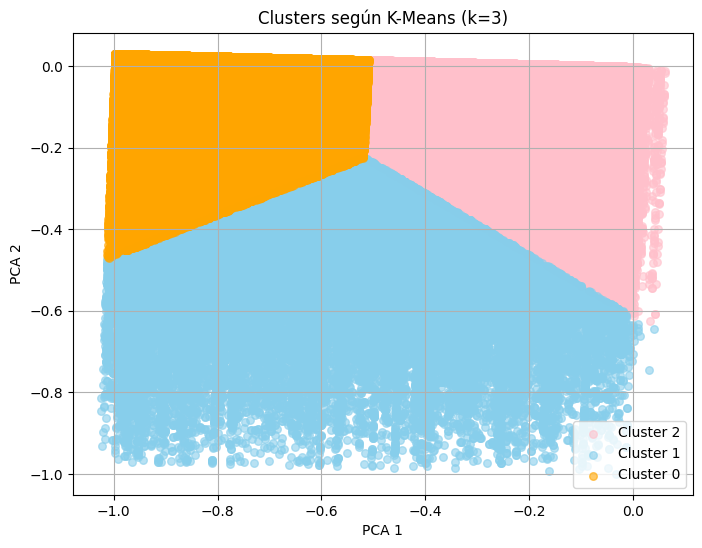

In [ ]:
# Visualización de los clsuters
df_plot = df_k3.select("pca_features", "prediction").toPandas()
df_plot["PCA1"] = df_plot["pca_features"].apply(lambda x: x[0])
df_plot["PCA2"] = df_plot["pca_features"].apply(lambda x: x[1])

# Crear mapa de colores personalizados
colors = {0: "orange", 1: "skyblue", 2: 'pink'}

plt.figure(figsize=(8,6))
for cluster_id in df_plot["prediction"].unique():
    subset = df_plot[df_plot["prediction"] == cluster_id]
    plt.scatter(subset["PCA1"], subset["PCA2"],
                label=f"Cluster {cluster_id}",
                c=colors[cluster_id], s=30, alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters según K-Means (k=3)")
plt.legend()
plt.grid(True)
plt.show()


### Análisis de clusters

* Cluster 0: agrupo a clientes que compran frecuentemente y eligen productos regulares.
* Cluster 1: agrupo a una cantidad mayor de clientes pero que son ocasionales, llevan más cantidad de productos y son un poco más caros que el grupo 0.
* Cluster 2: agrupo a los clientes se podría decir que más 'valiosos', porque tiene la mayor cantidad de transacciones, compran los porductos más caros y en buena cantidad, además generan el mayor porcentaje de ganancias.

### Grafico

El gráfico muestra una buena separación de los clústeres, sin sobreposición, lo que demuestra una composición muy compacta de cada tipo de cliente.

# Conclusión final

En este parcial desarrolle la implementación de Spark con MLlib para analizar un dataset sobre comercio online, con el fin de aplicar un modelo de clustering y detectar una segmentación de clientes.

Utilice funciones vistas en clase como 'filter', 'lambda', 'Sparksesion' y 'VectorAssembler'.

Agregue funciones que investigue como el modelo de clustering y PCA específico para Spark, donde obtuve un muy buen porcetanje en el PCA (95%) pero bajo un poco en el análisis de Silhuette Score(65% el mejor). Sin embargo, el resultado fue una sólida segmentación de tres grupos diferentes de clientes, que podrían servir al comercio para ofrecerles servicios más personalizados y alineados a las necesidades de cada uno.